# Simple Graph Neural Networks for Velocity Sim2Real Transfer
---
> Graph neural network model for vertex dynamics and tension prediction

- All simulated movies, regardless of their simulation param-s, use the same *normalisation constants*.
- Hara movies (node velocity data) and ablation (recoil data) movies have different spatio-temporal resolutions:
    - After scaling them to the same length scale and frame rate (microns/10s), we use the average edge length to normalise spatial variables (displacement and position; frame rate is assumed to be 10s for all movies including the simulated movies)

|Dataset | Details | Shortname| Avg. edge len.| Transforms (Normalisation)|
|:---:|:---|:---|---:|:---|
|Synthetic datasets     | vertex dynamics simulations| "train" and "val"| 1.0 a.u.| `[Pos2Vec(scale=10*1.0)`, `ScaleVelocity(0.5*1.0)`, `ScaleTension(0.634,shift=0.6)`, `ScalePressure(0.33,shift=0.1)]`|
|Hara movies    | no force information       | "hara"| 26.32 pixels|`[Pos2Vec(scale=10*26.32)`,`ScaleVelocity(0.5*26.32)]`|
|Hara ablation | short movies w/ recoil data| "abln"| 26.32*0.4/0.21 pixels | (not used for testing velocity) |


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import torch
from os import path
import datetime

from torch_geometric.data import Data, DataLoader
import torch_geometric.transforms as T

from torch_geometric.utils import to_networkx, from_networkx
import networkx as nx
from simgnn.datautils import load_array, load_graph

import matplotlib.pyplot as plt
import matplotlib
plt.style.use('ggplot')
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10,10) # use larger for presentation
matplotlib.rcParams['font.size']= 16 # use 14 for presentation

In [3]:
from simgnn.datasets import persistence_loss, VertexDynamics, HaraMovies
from simgnn.train import train_model, write_log, load_log, predict, predict_batch
from simgnn.transforms import Pos2Vec, ScaleVelocity, ScaleTension, ScalePressure, Reshape_x
# from torch_geometric.utils import to_undirected as T_undir

In [4]:
device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda')
dtype = torch.float32
print(f'Defaults:\n |-device: {device}\n |-dtype : {dtype}')

Defaults:
 |-device: cuda
 |-dtype : torch.float32


## Training

### Datasets

`CellData` prop-s (graph data objects):
- `x` : `(#nodes, WindowWidth, 2)` *node features*
- `y` : `(#nodes, 2)` *node targets (velocities)*.
- `pos` : `(#nodes, 2)` *node positions*.
- `edge_attr` : `(#edges, 2)` or `(#edges, #edge_features)` *edge features  (relative Cartesian positions of connected nodes)*.
- `edge_index` : `(2, #edges)` *edge indices*.
- `edge_tensions` : `(#edges,)` *edge targets (line tensions)*.
- `node2cell_index` : `(2, #cell2node_edges)`, `node2cell`-> *first row is node indices and second row is cell indices;
- `cell2node_index` : `(2, #cell2node_edges)`, `cell2node`-> *first row is cell indices and second row is node indices*.
- `cell_pressures` : `(#cells,)` *cell targets (cell pressures)*.

In [5]:
!rm -dr simgnn_data/single_distr_sims/train/processed
# !rm -dr simgnn_data/single_distr_sims/val/processed
!rm -dr simgnn_data/unimodal_wbasetens_sims/train/processed
!rm -dr simgnn_data/unimodal_wbasetens_sims/val/processed
!rm -dr simgnn_data/hara_movies/processed

In [6]:
!rm -dr simgnn_data/hara_movies_as_sep_datasets/hara_seg001/processed/
!rm -dr simgnn_data/hara_movies_as_sep_datasets/hara_seg003/processed/
!rm -dr simgnn_data/hara_movies_as_sep_datasets/hara_seg005/processed/
!rm -dr simgnn_data/unimodal_wbasetens_sims/val/processed/
!rm -dr simgnn_data/hara_movies/processed/

rm: cannot remove 'simgnn_data/unimodal_wbasetens_sims/val/processed/': No such file or directory
rm: cannot remove 'simgnn_data/hara_movies/processed/': No such file or directory


- Average lengths

In [7]:
window_size = 5

In [8]:
l_0 = {'sim':1.0, 'single_distr_sims':1.1, 'unimodal_wbasetens_sims':0.91, 'hara':26.32, 'abln':50.13}

In [9]:
# Normalisation: for simulated data (simul params ~ normal distr-s): l0=1.0, Hara_movie: l0=26.32
# Tnorm = T.Compose([Pos2Vec(scale=1.0*10.0) , ScaleVelocity(1.0*0.5), Reshape_x((-1,window_size*2)) ] )
# Hara movie normalisation
# Tnorm_hara = T.Compose([Pos2Vec(scale=10*26.32) , ScaleVelocity(0.5*26.32), Reshape_x((-1,window_size*2))])

# Use mean edge len w/o additional scaling for vel-y and edge len-s
Tnorms = {k : T.Compose([Pos2Vec(scale=l_0[k]) , ScaleVelocity(l_0[k]), Reshape_x((-1,window_size*2)) ] )
          for k in ['sim', 'hara']
         }

velocity_scale = {'train':l_0['sim'], 'val':l_0['sim'], 'val2':l_0['sim'], 'hara':l_0['hara']}

In [11]:
# Hara movie datasets
# seg001_raw = HaraMovies('simgnn_data/hara_movies/', window_size=window_size, transform=Tnorms['hara'])
# seg001 = HaraMovies('simgnn_data/hara_movies_as_sep_datasets/hara_seg001/', window_size=window_size,
#                     transform=Tnorms['hara'],smoothing=True, sma_lag_time=4)
# seg003 = HaraMovies('simgnn_data/hara_movies_as_sep_datasets/hara_seg003/', window_size=window_size,
#                     transform=Tnorms['hara'],smoothing=True, sma_lag_time=4)
# seg005 = HaraMovies('simgnn_data/hara_movies_as_sep_datasets/hara_seg005/', window_size=window_size,
#                     transform=Tnorms['hara'],smoothing=True, sma_lag_time=4)

hara = HaraMovies('simgnn_data/hara_movies/', window_size=window_size, transform=Tnorms['hara'], smoothing=True, sma_lag_time=4)


# Simulation datasets
sim1 = VertexDynamics('./simgnn_data/unimodal_wbasetens_sims/train/', window_size=window_size, transform=Tnorms['sim'])
sim1_val = VertexDynamics('./simgnn_data/unimodal_wbasetens_sims/val/', window_size=window_size, transform=Tnorms['sim'])
sim2 = VertexDynamics('./simgnn_data/single_distr_sims/train/', window_size=window_size, transform=Tnorms['sim'])
sim2_val = VertexDynamics('./simgnn_data/single_distr_sims/val/', window_size=window_size, transform=Tnorms['sim'])

datasets_dict = {'train': sim1,
                 'val': sim1_val,
                 'val2' : sim2_val,
                 'hara' : hara,
#                  'early' : seg001[-5:],
#                  'mid'   : seg003[-5:],
#                  'late'  : seg005[-5:],
#                 'raw': seg001_raw[len(seg001_raw)//3-1-5:len(seg001_raw)//3-1]
                }
dataset_legend={'train': 'Train(sim1)',
                'val': 'Val',
                'val2': 'sim2sim',
                'hara': 'Hara',
               'early': 'Hara(early)',
                'mid': 'Hara(mid)',
                'late': 'Hara(late)',
               'raw': 'Hara(early:raw)'}

# datasets_dict = {'train': sim1,
#                  'val': sim2,
#                  'early' : seg001[-5:],
#                  'mid'   : seg003[-5:],
#                  'late'  : seg005[-5:]}
# dataset_legend={'train': 'Train (sim1)',
#                 'val': 'Val(sim2)',
#                 'early': 'Hara (early)',
#                 'mid': 'Hara(mid)',
#                 'late': 'Hara(late)'}

Processing...
Done!
Processing...
Done!
Processing...
Done!


train : VertexDynamics(280)
size:280

Frame 1:
CellData(cell2node_index=[2, 480], cell_pressures=[80], edge_attr=[275, 2], edge_index=[2, 275], edge_tensions=[275], node2cell_index=[2, 480], pos=[196, 2], x=[196, 10], y=[196, 2])


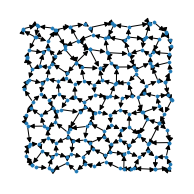

In [12]:
k='train'
print('{} : {}\nsize:{}\n\nFrame 1:\n{}'.format(k,datasets_dict[k],len(datasets_dict[k]),datasets_dict[k][0]))
plt.figure(figsize=[2.5,2.5])
nx.draw(to_networkx(datasets_dict[k][0]),pos=dict(enumerate(datasets_dict[k][0].pos.numpy())), node_size=10)

#### Helper functions

In [13]:
def plot_losses(train_log, loaders, dataset_legend,figsize=[15,8]):
    if figsize is not None:
        plt.figure(figsize=figsize)
    training_epochs = np.arange(train_log['total_epochs'])
    for data_name in loaders:
        plt.plot(training_epochs, train_log[f'{data_name}_loss_tot'],lw=3,label=f'{dataset_legend[data_name]}')
    plt.legend();


def plot_velocity_predictions(vel_pred, vel_tgt, dataset_legend, figsize=[15,7]):
    var_type = 0
    var_name = '$\Delta{}x$'

    for data_name in vel_pred:
        minY, maxY  = torch.cat(vel_tgt[data_name],dim=0).min(), torch.cat(vel_tgt[data_name],dim=0).max()

        fig,axs = plt.subplots(nrows=1,ncols=2,sharex=True,sharey=True,figsize=figsize)    
        for k,ax in enumerate(axs):
            ax.plot([minY,maxY], [minY,maxY],'--',color='b',lw=2,alpha=.5)
            ax.plot(torch.cat(vel_tgt[data_name], dim=0)[:,k],
                    torch.cat(vel_pred[data_name], dim=0)[:,k], 'o',ms=10,mfc='tomato',alpha=.25)
            ax.set_xlabel('True');
            ax.set_ylabel('Predicted')
            ax.set_title(f'{var_name}$_{k}$');
        plt.suptitle(f'{dataset_legend[data_name]}')
        plt.show()

#### Persistence Loss

In [14]:
print('Persistence:')
for k in datasets_dict:
    print(f'\t- {dataset_legend[k]}: {persistence_loss(datasets_dict[k])}')

Persistence:
	- Train(sim1): {'mae': 0.033784267, 'mse': 0.0021331417}
	- Val: {'mae': 0.032130886, 'mse': 0.0019259002}
	- sim2sim: {'mae': 0.031817768, 'mse': 0.002040872}
	- Hara: {'mae': 0.011888929, 'mse': 0.0002410337}


In [48]:
len(datasets_dict['train'])

280

### Experiments

#### Plain MLP
> y=MLP(x) models (no graph), uses single node trends to predict trajectory

- Train on 5 movies from same sim param distrib.
    - Best MLP model for `window_size=5`: `net = Plain_MLP(in_features=window_size*2, out_features=2, hidden_dims=[16,8,8,8,4],dropout_p=dropout_p)`
- Using 5+5 movies from two different sim param distrib-s
    - Needs more complex model.

In [15]:
from simgnn.models import Plain_MLP, PlainSquaredMLP

In [16]:
torch.manual_seed(0)

H_dims = [128,128,128,16]  # [128,16], [128,128,128,16], [128,128,128,128,128,16], [128,128,128,128,128,128,128,16]

dropout_p = 0
num_epochs = 20
lr = 0.001
bs = 2
loss_func = torch.nn.MSELoss(reduction='mean')
# loss_func = torch.nn.L1Loss(reduction='mean')

net = Plain_MLP(in_features=window_size*2, out_features=2, hidden_dims=H_dims,dropout_p=dropout_p).to(device)
# net = PlainSquaredMLP(in_features=window_size*2, out_features=2, hidden_dims=H_dims,dropout_p=dropout_p).to(device)

opt = torch.optim.Adam(net.parameters(), lr=lr)
# opt = torch.optim.SGD(net.parameters(), lr=lr, momentum=0.9)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, 'min')

# in order to track the batch id for var-s add its key to "follow_batch":
loaders = {'train' : DataLoader(datasets_dict['train'], batch_size=bs, shuffle=True),
           'val': DataLoader(datasets_dict['val'], batch_size=bs),
           'val2': DataLoader(datasets_dict['val2'], batch_size=bs),
#           'hara': DataLoader(datasets_dict['hara'], batch_size=bs)
          }
# loaders = {'train' : DataLoader(datasets_dict['train'], batch_size=bs, shuffle=True),
#            'val':    DataLoader(datasets_dict['val'], batch_size=bs),
#            'val2':    DataLoader(datasets_dict['val2'], batch_size=bs),
#            'early':    DataLoader(datasets_dict['early'], batch_size=bs),
#            'mid':   DataLoader(datasets_dict['mid'], batch_size=bs),
#            'late': DataLoader(datasets_dict['late'], batch_size=bs)}

model_states = list(loaders.keys())
use_force_loss = {k:[False,False] for k in loaders}

return_best = False

model_name = datetime.datetime.now().strftime('%d%m%Y_%H%M%S')+f'_{net.__class__.__name__}_dp{dropout_p}bs{bs}w{window_size}{"best" if return_best else ""}'
save_dir = './simgnn_data/saved_models/'

In [17]:
print(model_name,end='\n---\n')
net, train_log = train_model(net, loaders, opt, num_epochs=num_epochs, scheduler=None, device=device, model_states = model_states,
                               loss_func = loss_func, use_force_loss=use_force_loss,
                               return_best=return_best)

05022022_043825_Plain_MLP_dp0bs2w5
---
Training param-s: #epochs=20, metric=MSELoss(), batch_size=2, optim=Adam, sch-r=none, return_best=False
---
Epoch 0/19: train_loss_tot=0.003649; train_loss_y=0.003649; |val_loss_tot=0.0005629; |val2_loss_tot=0.0007566; |3s
Epoch 1/19: train_loss_tot=0.0004714; train_loss_y=0.0004714; |val_loss_tot=0.0003094; |val2_loss_tot=0.000474; |7s
Epoch 2/19: train_loss_tot=0.0003398; train_loss_y=0.0003398; |val_loss_tot=0.0002762; |val2_loss_tot=0.0004227; |10s
Epoch 3/19: train_loss_tot=0.0003133; train_loss_y=0.0003133; |val_loss_tot=0.0002609; |val2_loss_tot=0.0004074; |13s
Epoch 4/19: train_loss_tot=0.0003033; train_loss_y=0.0003033; |val_loss_tot=0.0002544; |val2_loss_tot=0.0003924; |16s
Epoch 5/19: train_loss_tot=0.0002962; train_loss_y=0.0002962; |val_loss_tot=0.0002558; |val2_loss_tot=0.0003909; |19s
Epoch 6/19: train_loss_tot=0.0002913; train_loss_y=0.0002913; |val_loss_tot=0.0002496; |val2_loss_tot=0.0003845; |22s
Epoch 7/19: train_loss_tot=0.000

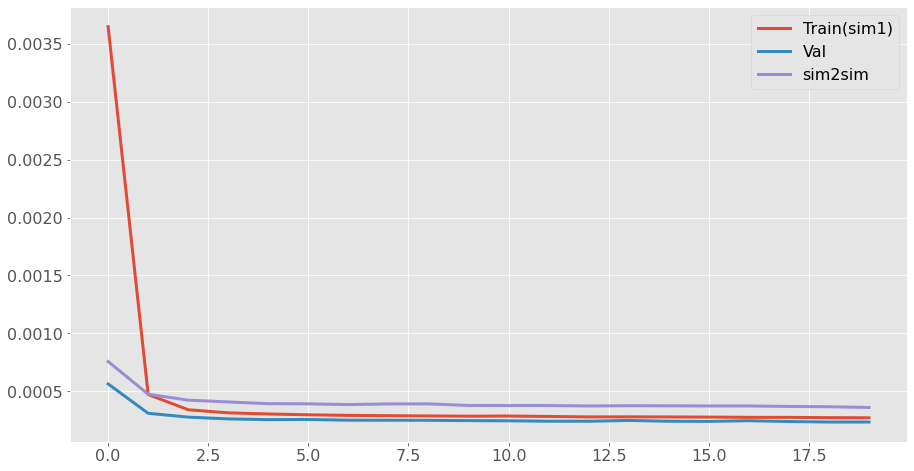

In [18]:
# plot losses
plot_losses(train_log, loaders, dataset_legend); plt.show()

- train_loss_tot =0.00026682127647559257;
- train_loss_y =0.00026682127647559257;
- train_loss_T =0.0;
- train_loss_P =0.0;
- val_loss_tot =0.00023380352451489214;
- val_loss_y =0.00023380352451489214;
- val_loss_T =0.0;
- val_loss_P =0.0;
- val2_loss_tot =0.00035954246947751244;
- val2_loss_y =0.00035954246947751244;
- val2_loss_T =0.0;
- val2_loss_P =0.0;



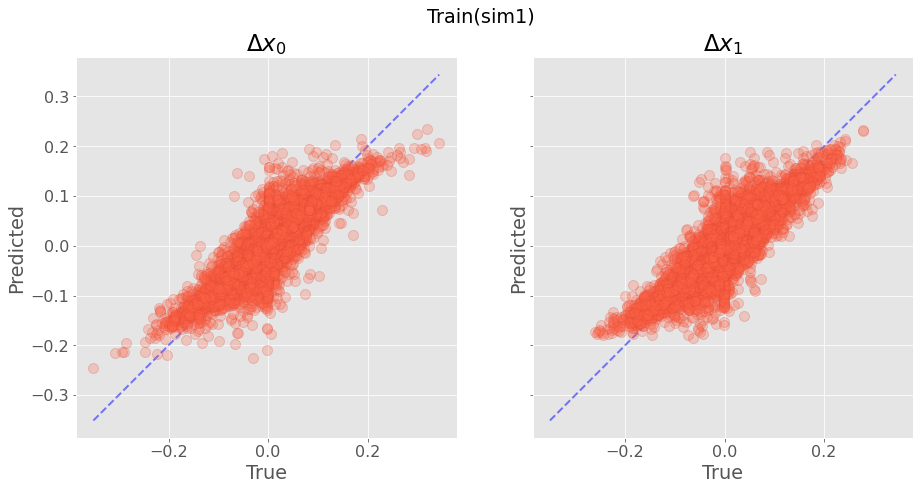

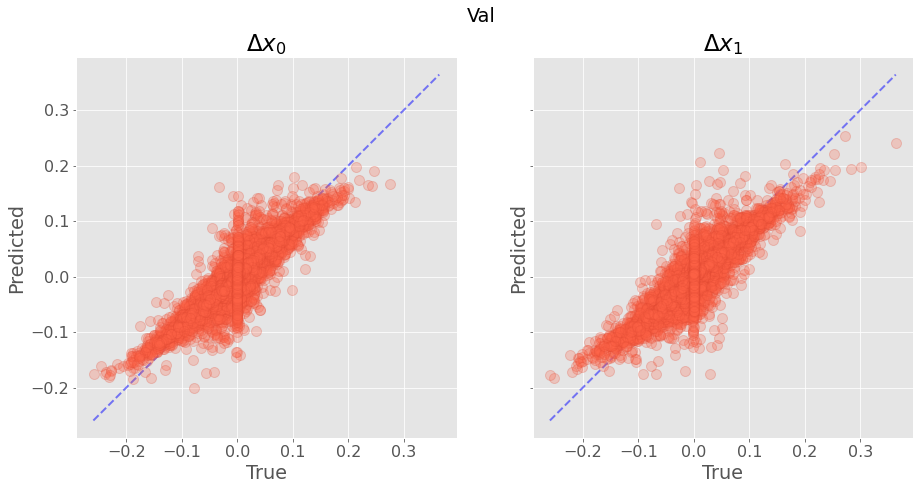

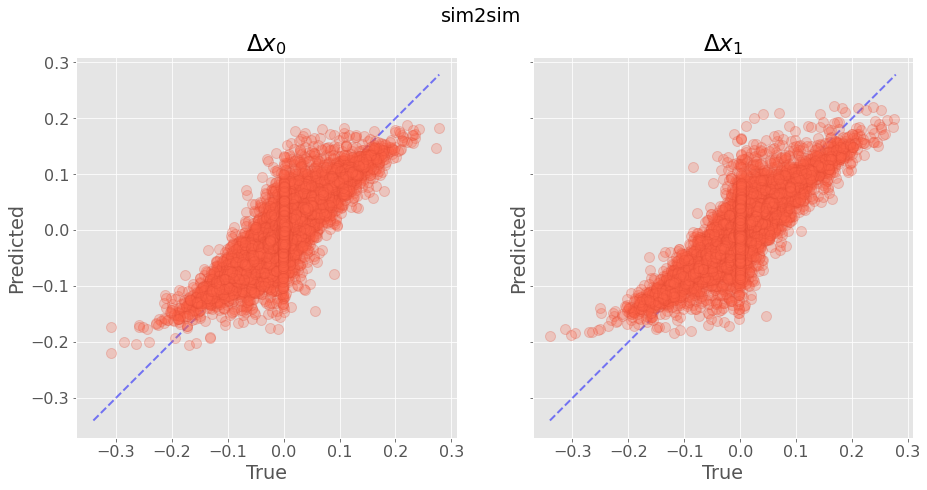

In [19]:
pred_loaders = {'train' : DataLoader(datasets_dict['train'], batch_size=bs, shuffle=True),
           'val': DataLoader(datasets_dict['val'], batch_size=bs),
           'val2': DataLoader(datasets_dict['val2'], batch_size=bs),
#           'hara': DataLoader(datasets_dict['hara'], batch_size=bs)
          }
# compute predictions and plot them
pred_out, tgt_out, sample_losses = predict_batch(net, pred_loaders,
                                                 loss_func=torch.nn.MSELoss(reduction='sum'),
                                                 use_force_loss = {k: False for k in pred_loaders},
                                                 return_losses = True, device=device)
print(''.join([f'- {k} ={sample_losses[k]};\n' for k in sample_losses]))

plot_velocity_predictions(pred_out[0], tgt_out[0], dataset_legend)

In [17]:
# write_log(f'{path.join(save_dir, model_name)}_train_log.pkl',train_log)
# torch.save(net.state_dict(), f'{path.join(save_dir, model_name)}_net.pkl')
# print(f'Model weights saved in \n{path.join(save_dir, model_name)}_net.pkl')

- **as MOVIES**

In [44]:
dataset_mov_names = {}
dataset_mov_idx = {}
dataset_mov = {}

for dataset_k in ['val', 'val2']: #  ['train', 'val', 'val2', 'hara']:
    print(dataset_k)

    d_names_list = [k.split('_')[2] for k in datasets_dict[dataset_k].processed_file_names]
    
    dataset_mov_names[dataset_k] = {k : ki for ki, k in enumerate(np.unique(d_names_list))}
    
    dataset_mov_idx[dataset_k] = torch.tensor([dataset_mov_names[dataset_k][k] for k in d_names_list])
    
    dataset_mov[dataset_k] = {k:datasets_dict[dataset_k][dataset_mov_names[dataset_k][k]==dataset_mov_idx[dataset_k]]
                              for k in dataset_mov_names[dataset_k]}
dataset_mov

val
val2


{'val': {'sim005': VertexDynamics(56), 'sim006': VertexDynamics(56)},
 'val2': {'sim005': VertexDynamics(56), 'sim006': VertexDynamics(56)}}

- **Model Predictions for Movies**; Predict `Velocity[T+1]` for movies

In [51]:
from simgnn.train import np_loss_wrt_time, predict_dataset

from scipy.stats import pearsonr

In [52]:
velocity_scale

{'train': 1.0, 'val': 1.0, 'val2': 1.0, 'hara': 26.32}

In [53]:
ignore_short_edges, edge_len_threshold = False, 10**-4

In [57]:
dataset_mov[dataset_k][mov_i][0].edge_id

In [58]:
dataset_mov[dataset_k][mov_i][0]

CellData(cell2node_index=[2, 600], cell_pressures=[100], edge_attr=[339, 2], edge_index=[2, 339], edge_tensions=[339], node2cell_index=[2, 600], pos=[240, 2], x=[240, 10], y=[240, 2])

In [55]:
model_results = {}
loss_type = 'mse'

for dataset_k in dataset_mov:
    print('-'*10+'\n'+dataset_k)
    model_results[dataset_k] = {}
    for mov_i in dataset_mov[dataset_k]:
        print('\t',mov_i,f': len={len(dataset_mov[dataset_k][mov_i])};',
              f'E_n={torch.unique(dataset_mov[dataset_k][mov_i][0].edge_id).size(0)};',
              f'V_n={dataset_mov[dataset_k][mov_i][0].num_nodes};',
              f'C_n={dataset_mov[dataset_k][mov_i][0].num_cells};', end=' ')

        model_results[dataset_k][mov_i] = predict_dataset(net, dataset_mov[dataset_k][mov_i],device=device, concat=True)
        
        print(model_results[dataset_k][mov_i])
        
        break
        
        edge_index = dataset_mov[dataset_k][mov_i][0].edge_index[:,torch.unique(dataset_mov[dataset_k][mov_i][0].edge_id)]
        model_results[dataset_k][mov_i]['edge_index'] = edge_index
        
        pos = np.concatenate([d.pos.reshape(1,-1,2) for d in dataset_mov[dataset_k][mov_i]],axis=0)
        model_results[dataset_k][mov_i]['targets']['pos'] = pos
        
        edge_lengths = np.linalg.norm(pos[:, edge_index[1],:] - pos[:, edge_index[0],:], axis=-1)
        model_results[dataset_k][mov_i]['targets']['edge_lengths'] = edge_lengths
        
        dx_unnorm = velocity_scale[dataset_k]*model_results[dataset_k][mov_i]['predictions']['velocity']
        # pos predictions w/ velocity (except for first pos)
        pos_preds = np.concatenate([pos[:1],(pos+dx_unnorm)[:-1]], axis=0)
        model_results[dataset_k][mov_i]['predictions']['pos'] = pos_preds

        model_results[dataset_k][mov_i]['predictions']['edge_lengths'] = np.linalg.norm(pos_preds[:, edge_index[1],:] - pos_preds[:, edge_index[0],:], axis=-1)
        if ignore_short_edges:
            edge_mask = np.all(np.concatenate([dk.edge_length.numpy().reshape(1,-1)
                                               for dk in dataset_mov[dataset_k][mov_i]], axis=0) > edge_len_threshold, axis=0)
            model_results[dataset_k][mov_i]['predictions']['edge_masks'] = edge_mask
        else:
            model_results[dataset_k][mov_i]['predictions']['edge_masks'] = None
        
        model_results[dataset_k][mov_i]['loss'] = {}
        
        # velocity losses
        if len(model_results[dataset_k][mov_i]['targets']['velocity']) > 0:
            model_results[dataset_k][mov_i]['loss']['velocity'] = np_loss_wrt_time(model_results[dataset_k][mov_i]['predictions']['velocity'],
                                                                                   model_results[dataset_k][mov_i]['targets']['velocity'])
        else:
            model_results[dataset_k][mov_i]['loss']['velocity'] = np.full((model_results[dataset_k][mov_i]['predictions']['velocity'].shape[1],), np.nan)
        
        # tension losses
        if len(model_results[dataset_k][mov_i]['targets']['tension']) > 0:
            model_results[dataset_k][mov_i]['loss']['tension'] = np_loss_wrt_time(model_results[dataset_k][mov_i]['predictions']['tension'],
                                                                                  model_results[dataset_k][mov_i]['targets']['tension'])
        else:
            model_results[dataset_k][mov_i]['loss']['tension'] = np.full((model_results[dataset_k][mov_i]['predictions']['tension'].shape[1],), np.nan)

        if ignore_short_edges:
            model_results[dataset_k][mov_i]['loss']['tension_mask'] = model_results[dataset_k][mov_i]['loss']['tension'].copy()
            model_results[dataset_k][mov_i]['loss']['tension_mask'][~edge_mask] = np.nan
        else:
            model_results[dataset_k][mov_i]['loss']['tension_mask'] = None
        model_results[dataset_k][mov_i]['loss']['edge_lengths'] = np_loss_wrt_time(model_results[dataset_k][mov_i]['predictions']['edge_lengths'],
                                                                                   model_results[dataset_k][mov_i]['targets']['edge_lengths'])
        
        print(f"Losses: Vel-y={np.nanmean(model_results[dataset_k][mov_i]['loss']['velocity']):6.4f}; "+
              f"E_len={np.nanmean(model_results[dataset_k][mov_i]['loss']['edge_lengths']):6.4f}; "+
              f"Tension={np.nanmean(model_results[dataset_k][mov_i]['loss']['tension']):6.4f};"+
             f"Tension(mask)={np.nanmean(model_results[dataset_k][mov_i]['loss']['tension_mask']) if ignore_short_edges else 0.0:6.4f}")

----------
val


TypeError: _unique2(): argument 'input' (position 1) must be Tensor, not NoneType

---

#### Load Model and Check Performance

In [ ]:
dropout_p = 0.42
# net = Plain_MLP(in_features=window_size*2, out_features=2, hidden_dims=[32,16,16,16,8,8],dropout_p=dropout_p).to(device)
# net_weights_dict = torch.load(path.join(save_dir, '31052021_064810_Plain_MLP_dp0.1bs32w5best_net.pkl'), map_location=device)

net = Plain_MLP(in_features=window_size*2, out_features=2, hidden_dims=[64,32,16,16,16,16],dropout_p=dropout_p).to(device)
net_weights_dict = torch.load(path.join(save_dir, '29052021_190220_Plain_MLP_dp0.5bs32w5_net.pkl'), map_location=device)

net.load_state_dict(net_weights_dict)
net.eval();

In [ ]:
# predict(net, train1[0], loss_func=loss_func, use_force_loss = use_force_loss['train'], return_losses = False, device=device)

In [ ]:
from simgnn.train import predict, predict_batch
# plot losses
# plot_losses(train_log, loaders, dataset_legend); plt.show()
pred_out, tgt_out, sample_losses = predict_batch(net, loaders, loss_func=torch.nn.MSELoss(reduction='mean'),
                                                 use_force_loss = use_force_loss, return_losses = True, device=device)
print(''.join([f'- {k} ={sample_losses[k]};\n' for k in sample_losses]))
plot_velocity_predictions(pred_out[0], tgt_out[0], dataset_legend)

In [ ]:
# plt.figure(figsize=[35,10])
# ax1 = plt.subplot(1,4,1)
# ax1.plot(np.arange(train_log['total_epochs']),train_log['val_loss_y'],'orange',lw=4,label='Hara')
# ax1.hlines(0.0041163876,0,30)
# ax1.axis([0,30,0.00325,.0043]);
# ax1.legend();

# ax2 = plt.subplot(1,4,2,sharex=ax1,sharey=ax1)
# ax2.plot(np.arange(train_log['total_epochs']),train_log['early_loss_y'],'red',lw=4,label='Early',alpha=.7)
# ax2.hlines(0.0042118663,0,30)
# ax2.legend();

# ax3 = plt.subplot(1,4,3,sharex=ax1,sharey=ax1)
# ax3.plot(np.arange(train_log['total_epochs']),train_log['mid_loss_y'],'purple',lw=4,label='Middle',alpha=.7)
# ax3.hlines(0.00330922,0,30)
# ax3.legend();


# ax4 = plt.subplot(1,4,4,sharex=ax1)
# ax4.plot(np.arange(train_log['total_epochs']),train_log['late_loss_y'],'lime',lw=4,label='Late',alpha=.7)
# ax4.hlines(0.004734805,0,30)
# ax4.axis([0,30,0.004,.0048]);
# ax4.legend();

In [ ]:
# plt.figure(figsize=[15,8])
# plt.plot(np.arange(train_log['total_epochs']),train_log['sim_loss_tot'],'royalblue',lw=3,label='Sim')
# plt.plot(np.arange(train_log['total_epochs']),train_log['val_loss_y'],'orange',lw=4,label='Hara')
# plt.plot(np.arange(train_log['total_epochs']),train_log['early_loss_y'],'red',lw=3,label='Early',alpha=.7)
# plt.plot(np.arange(train_log['total_epochs']),train_log['mid_loss_y'],'purple',lw=3,label='Middle',alpha=.7)
# plt.plot(np.arange(train_log['total_epochs']),train_log['late_loss_y'],'lime',lw=3,label='Late',alpha=.7)
# plt.legend();
# plt.axis([0,30,0,.009]);


---

#### Single Message Passing Step
> Single MP step, uses graph and relative node positions w.r.t. connected neighbouring nodes

- Single MP step w/ a very simple Update mlp. Update stage is equivalent to the node model (plain mlp) w/ an additional edge features as messages.

In [20]:
from simgnn.models import Single_MP_step, SingleMPStepSquared
#mlp, Message, AggregateUpdate, Aggregate

In [38]:
net

Single_MP_step(
  (message): DiffMessage(
    (mlp): mlp(
      (layers): Sequential(
        (0): Linear(in_features=12, out_features=32, bias=True)
        (1): ReLU()
        (2): Linear(in_features=32, out_features=32, bias=True)
      )
    )
  )
  (relu): ReLU()
  (aggr_update): AggregateUpdate(
    (mlp): mlp(
      (layers): Sequential(
        (0): Linear(in_features=42, out_features=2, bias=True)
      )
    )
  )
)

In [39]:
torch.manual_seed(0)

dropout_p = 0
weight_decay = 0
num_epochs = 20
lr = 0.001
bs = 2
loss_func = torch.nn.MSELoss(reduction='mean')
# loss_func = torch.nn.L1Loss(reduction='mean')
# Deep model msg_dim=320; msg_nlayers=4; upd_dim=514; upd_nlayers=3
msg_dim = 32
msg_nlayers = 3 # in+out+#hidden_layers
upd_dim = 128
upd_nlayers = 3# in(msg,x)+out(y)+#hidden_layers

net = Single_MP_step(node_in_features=window_size*2, node_out_features=2, edge_in_features=2,
                     message_out_features=msg_dim, message_hidden_dims=[msg_dim for k in range(msg_nlayers-2)],
                     aggr='mean', update_hidden_dims=[upd_dim for k in range(upd_nlayers-2)], dropout_p=dropout_p).to(device)

opt = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=weight_decay)
# opt = torch.optim.SGD(net.parameters(), lr=lr, momentum=0.9)
# opt = torch.optim.Adamax(net.parameters(), lr=lr)
scheduler = None
# scheduler = torch.optim.lr_scheduler.StepLR(opt, 100, gamma=0.1)

# in order to track the batch id for var-s add its key to "follow_batch":
loaders = {'train' : DataLoader(datasets_dict['train'], batch_size=bs, shuffle=True),
           'val':    DataLoader(datasets_dict['val'], batch_size=bs),
           'val2':    DataLoader(datasets_dict['val2'], batch_size=bs),
#            'early':    DataLoader(datasets_dict['early'], batch_size=bs),
#            'mid':   DataLoader(datasets_dict['mid'], batch_size=bs),
#            'late': DataLoader(datasets_dict['late'], batch_size=bs)
          }
# this tracks batch id for "cell_pressures_batch" and "edge_index_batch" in addition to node batch ids

model_states = list(loaders.keys())
use_force_loss = {k:[False,False] for k in loaders}

return_best = False

model_name = datetime.datetime.now().strftime('%d%m%Y_%H%M%S')+f'_{net.__class__.__name__}_dp{dropout_p}bs{bs}w{window_size}{"best" if return_best else ""}'
save_dir = './simgnn_data/saved_models/'

In [40]:
print(model_name,end='\n---\n')
net, train_log = train_model(net, loaders, opt, num_epochs=num_epochs, scheduler=scheduler, device=device, model_states = model_states,
                               loss_func = loss_func, use_force_loss=use_force_loss, return_best=return_best)

05022022_045052_Single_MP_step_dp0bs2w5
---
Training param-s: #epochs=20, metric=MSELoss(), batch_size=2, optim=Adam, sch-r=none, return_best=False
---
Epoch 0/19: train_loss_tot=  0.0011; train_loss_y=  0.0011; |val_loss_tot=0.000422; |val2_loss_tot=0.0005948; |3s
Epoch 1/19: train_loss_tot=0.0004015; train_loss_y=0.0004015; |val_loss_tot=0.0003004; |val2_loss_tot=0.0004519; |6s
Epoch 2/19: train_loss_tot=0.0003299; train_loss_y=0.0003299; |val_loss_tot=0.0002675; |val2_loss_tot=0.0004124; |9s
Epoch 3/19: train_loss_tot=0.000303; train_loss_y=0.000303; |val_loss_tot=0.000253; |val2_loss_tot=0.0003906; |13s
Epoch 4/19: train_loss_tot=0.0002884; train_loss_y=0.0002884; |val_loss_tot=0.0002422; |val2_loss_tot=0.0003765; |16s
Epoch 5/19: train_loss_tot=0.0002753; train_loss_y=0.0002753; |val_loss_tot=0.0002332; |val2_loss_tot=0.0003592; |19s
Epoch 6/19: train_loss_tot=0.0002651; train_loss_y=0.0002651; |val_loss_tot=0.000223; |val2_loss_tot=0.0003454; |22s
Epoch 7/19: train_loss_tot=0.000

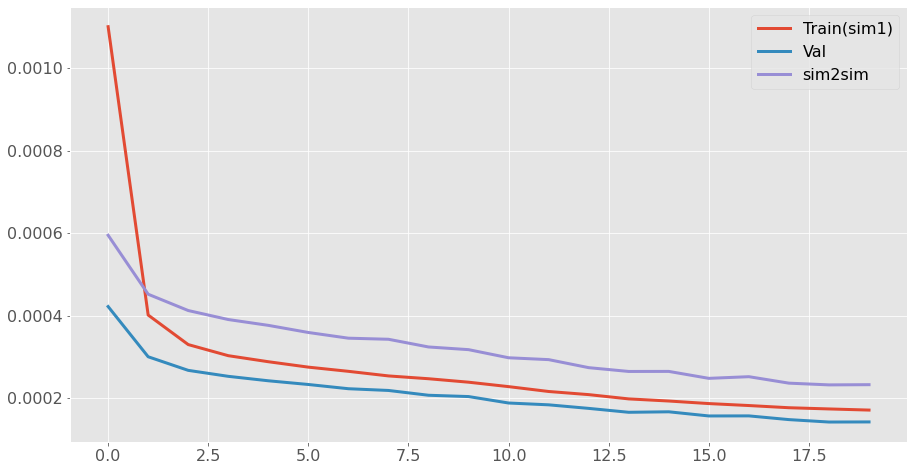

In [42]:
# plot losses
plot_losses(train_log, loaders, dataset_legend); plt.show()

- train_loss_tot =0.0001666462104324074;
- train_loss_y =0.0001666462104324074;
- train_loss_T =0.0;
- train_loss_P =0.0;
- val_loss_tot =0.00014251957252025996;
- val_loss_y =0.00014251957252025996;
- val_loss_T =0.0;
- val_loss_P =0.0;
- val2_loss_tot =0.00023277381250819007;
- val2_loss_y =0.00023277381250819007;
- val2_loss_T =0.0;
- val2_loss_P =0.0;



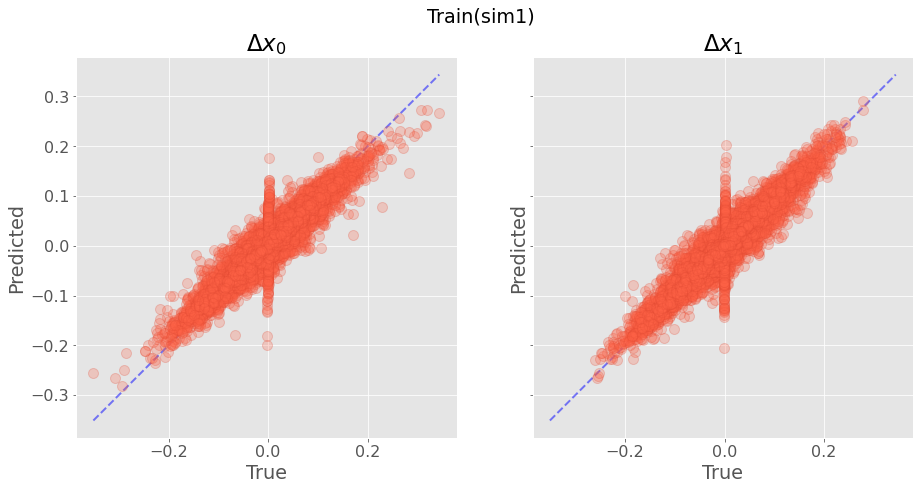

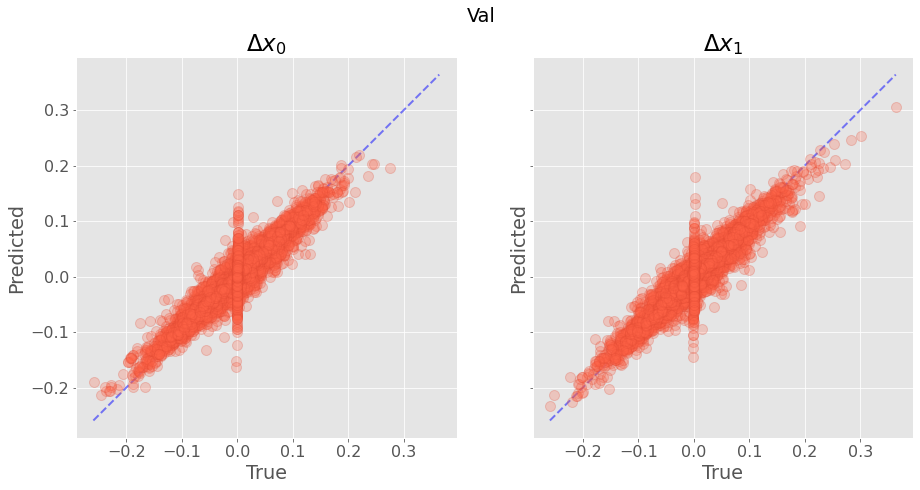

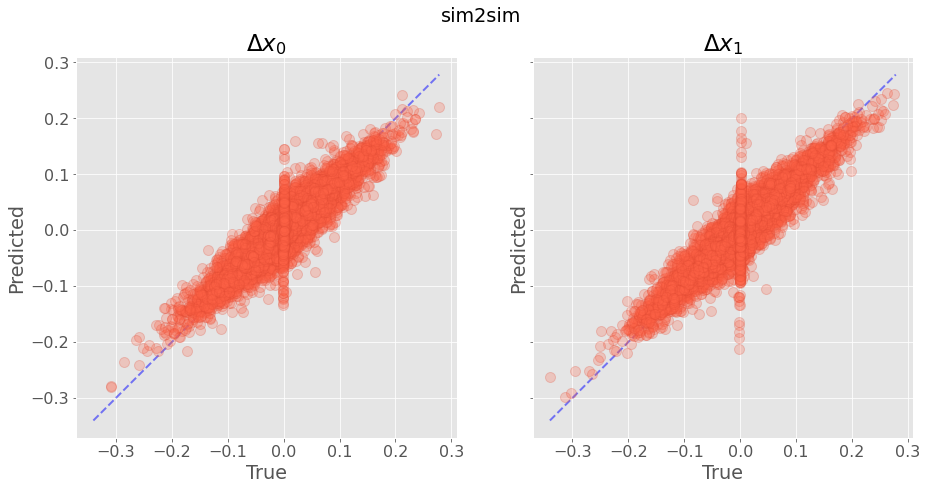

In [43]:
pred_loaders = {'train' : DataLoader(datasets_dict['train'], batch_size=bs, shuffle=True),
           'val': DataLoader(datasets_dict['val'], batch_size=bs),
           'val2': DataLoader(datasets_dict['val2'], batch_size=bs),
#           'hara': DataLoader(datasets_dict['hara'], batch_size=bs)
          }
# compute predictions and plot them
pred_out, tgt_out, sample_losses = predict_batch(net, pred_loaders,
                                                 loss_func=torch.nn.MSELoss(reduction='sum'),
                                                 use_force_loss = {k: False for k in pred_loaders},
                                                 return_losses = True, device=device)
print(''.join([f'- {k} ={sample_losses[k]};\n' for k in sample_losses]))

plot_velocity_predictions(pred_out[0], tgt_out[0], dataset_legend)

In [27]:
# # compute predictions and plot them
# pred_out, tgt_out, sample_losses = predict_batch(net, loaders, loss_func=torch.nn.MSELoss(reduction='sum'),
#                                                  use_force_loss = {k:False for k in loaders}, return_losses = True, device=device)
# print(''.join([f'- {k} ={sample_losses[k]};\n' for k in sample_losses]))

# plot_velocity_predictions(pred_out[0], tgt_out[0], dataset_legend)

In [42]:
write_log(f'{path.join(save_dir, model_name)}_train_log.pkl',train_log)
torch.save(net.state_dict(), f'{path.join(save_dir, model_name)}_net.pkl')
print(f'Model weights saved in \n{path.join(save_dir, model_name)}_net.pkl')

Model weights saved in 
./simgnn_data/saved_models/05062021_193518_Single_MP_step_dp0.4bs2w5_net.pkl
